# **Data collection and preprocessing**

In [1]:
# Import libraries
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np

# Step 1 : Load the Excel file
df = pd.read_excel('supermarket dataset.xlsx')

# Step 2: Convert Date and Create DateTime Column
df['Date'] = pd.to_datetime(df['Date'])
df['Time'] = df['Time'].astype(str)  # Convert Time to string format
df['DateTime'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Time'])
df.drop(columns=['Date', 'Time'], inplace=True)

# Step 3: Handle Missing Values
df.fillna(0, inplace=True)

# Step 4: Encode Categorical Variables (Exclude 'Product line', 'City', 'Branch')
label_encoders = {}
categorical_columns = ['Customer type', 'Gender', 'Payment']  # Exclude 'Product line', 'City', 'Branch'
for column in categorical_columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

# Step 5: Feature Engineering: Date-Time Features
df['Year'] = df['DateTime'].dt.year
df['Month'] = df['DateTime'].dt.month
df['Day'] = df['DateTime'].dt.day
df['DayOfWeek'] = df['DateTime'].dt.dayofweek
df['Hour'] = df['DateTime'].dt.hour

# Step 6: Add Additional Columns
df['RevenuePerUnit'] = df['Unit price'] * df['Quantity']
df['TotalTaxAmount'] = df['Total'] * 0.05
df['IsWeekend'] = df['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)
df.drop(columns=['DateTime'], inplace=True)

# Step 7: Log Transformation
df['LogQuantity'] = np.log1p(df['Quantity'])
df['LogTotal'] = np.log1p(df['Total'])
df['LogGrossIncome'] = np.log1p(df['gross income'])

# Step 8: Interaction Feature: Quantity * Unit Price
df['QuantityUnitPrice'] = df['Quantity'] * df['Unit price']

# Outlier Treatment for 'Total'
Q1 = df['Total'].quantile(0.25)
Q3 = df['Total'].quantile(0.75)
IQR = Q3 - Q1
df = df[(df['Total'] >= Q1 - 1.5 * IQR) & (df['Total'] <= Q3 + 1.5 * IQR)]

# Step 9: Scaling Numerical Features (Exclude 'Product line', 'City', 'Branch')
numerical_features = ['Unit price', 'Quantity', 'Tax 5%', 'Total', 'gross income', 'Rating']
scaler = StandardScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])

# Step 10: Save Preprocessed Data to Excel
df.to_excel('preprocessed_sales_data.xlsx', index=False)


# **Visualizations**

<ipython-input-2-edd56b421d21>:13: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Product line', y='Total', data=df, estimator=sum, ci=None)


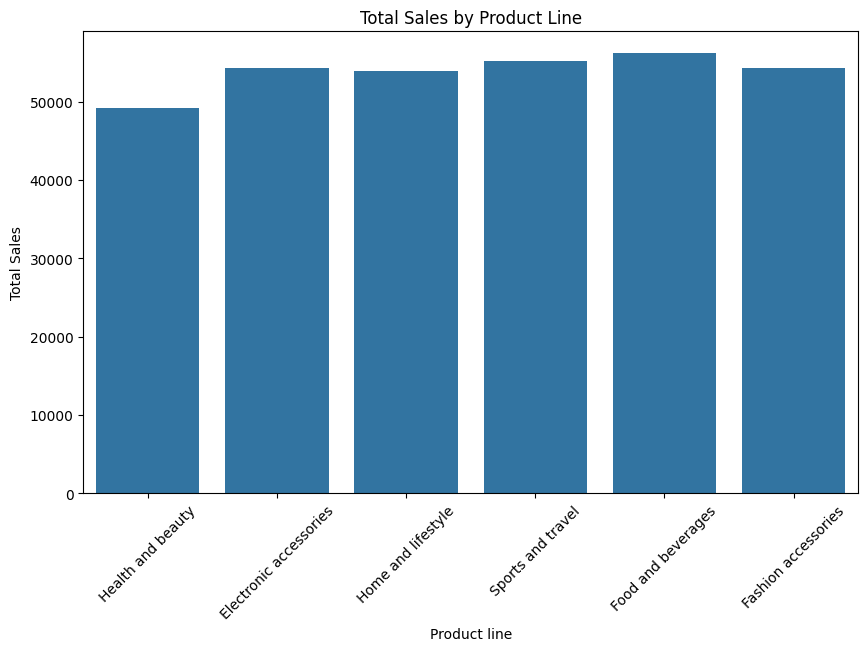

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load Data
df = pd.read_excel('supermarket dataset.xlsx')

# Convert Date column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# 1. Sales Distribution by Product Line
plt.figure(figsize=(10, 6))
sns.barplot(x='Product line', y='Total', data=df, estimator=sum, ci=None)
plt.title('Total Sales by Product Line')
plt.xticks(rotation=45)
plt.ylabel('Total Sales')
plt.show()

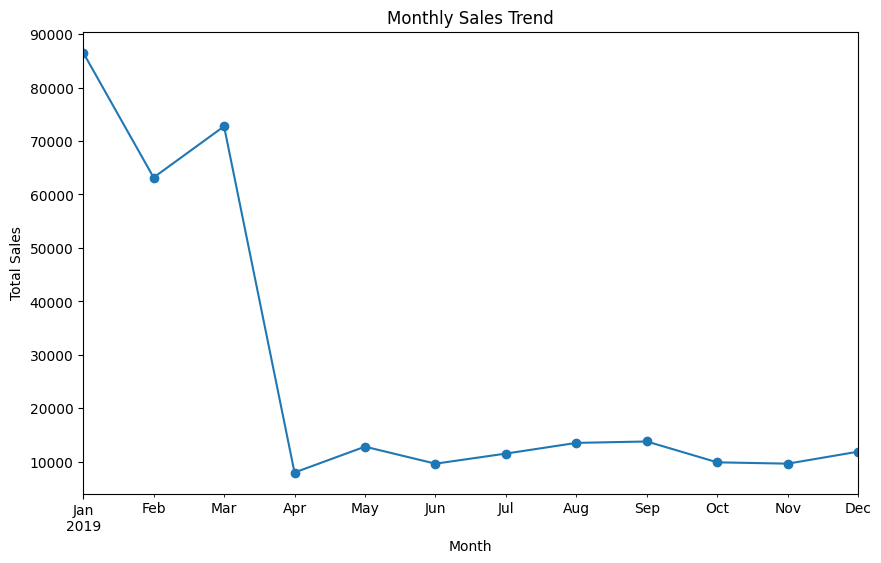

In [3]:
# 2. Sales Trends Over Time
sales_trend = df.groupby(df['Date'].dt.to_period('M'))['Total'].sum()
sales_trend.plot(kind='line', figsize=(10, 6), marker='o')
plt.title('Monthly Sales Trend')
plt.ylabel('Total Sales')
plt.xlabel('Month')
plt.show()


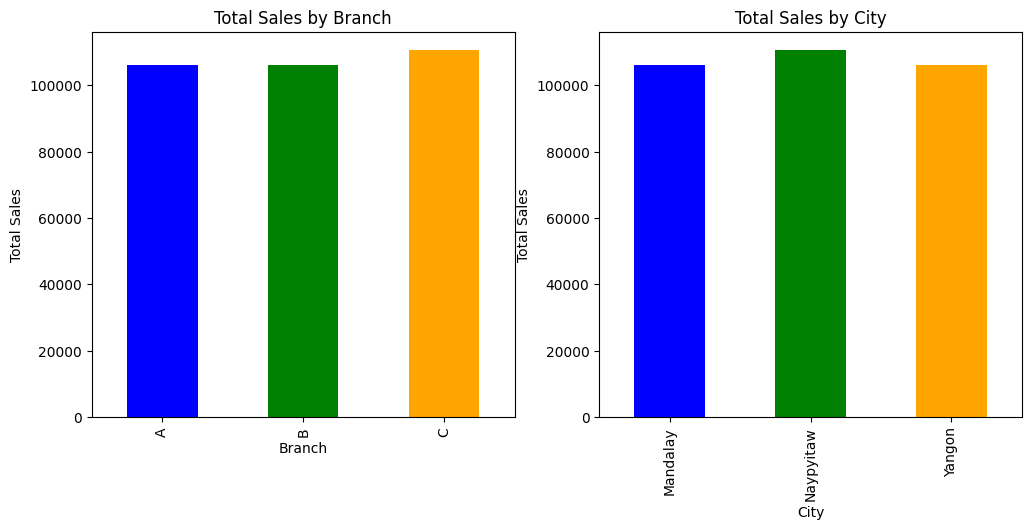

In [4]:
# 3. Branch/City-Wise Sales
branch_sales = df.groupby('Branch')['Total'].sum()
city_sales = df.groupby('City')['Total'].sum()
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
branch_sales.plot(kind='bar', color=['blue', 'green', 'orange'])
plt.title('Total Sales by Branch')
plt.ylabel('Total Sales')
plt.xlabel('Branch')
plt.subplot(1, 2, 2)
city_sales.plot(kind='bar', color=['blue', 'green', 'orange'])
plt.title('Total Sales by City')
plt.ylabel('Total Sales')
plt.xlabel('City')
plt.show()

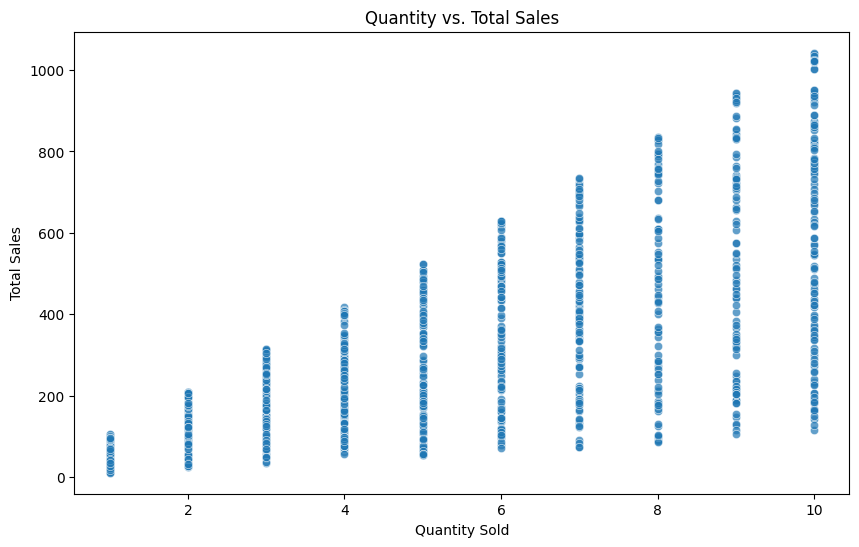

In [5]:
# 4. Quantity vs. Total Sales
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Quantity', y='Total', data=df, alpha=0.7)
plt.title('Quantity vs. Total Sales')
plt.xlabel('Quantity Sold')
plt.ylabel('Total Sales')
plt.show()

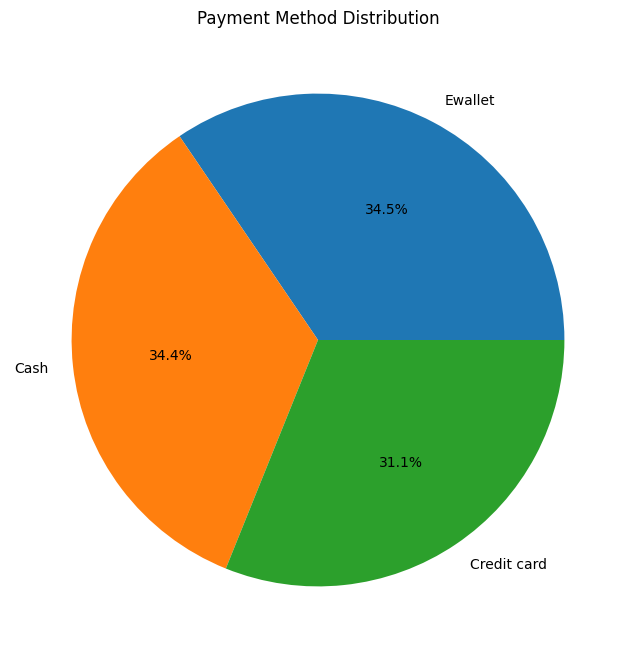

In [6]:
# 5. Payment Method Distribution
payment_counts = df['Payment'].value_counts()
payment_counts.plot(kind='pie', autopct='%1.1f%%', figsize=(8, 8))
plt.title('Payment Method Distribution')
plt.ylabel('')
plt.show()

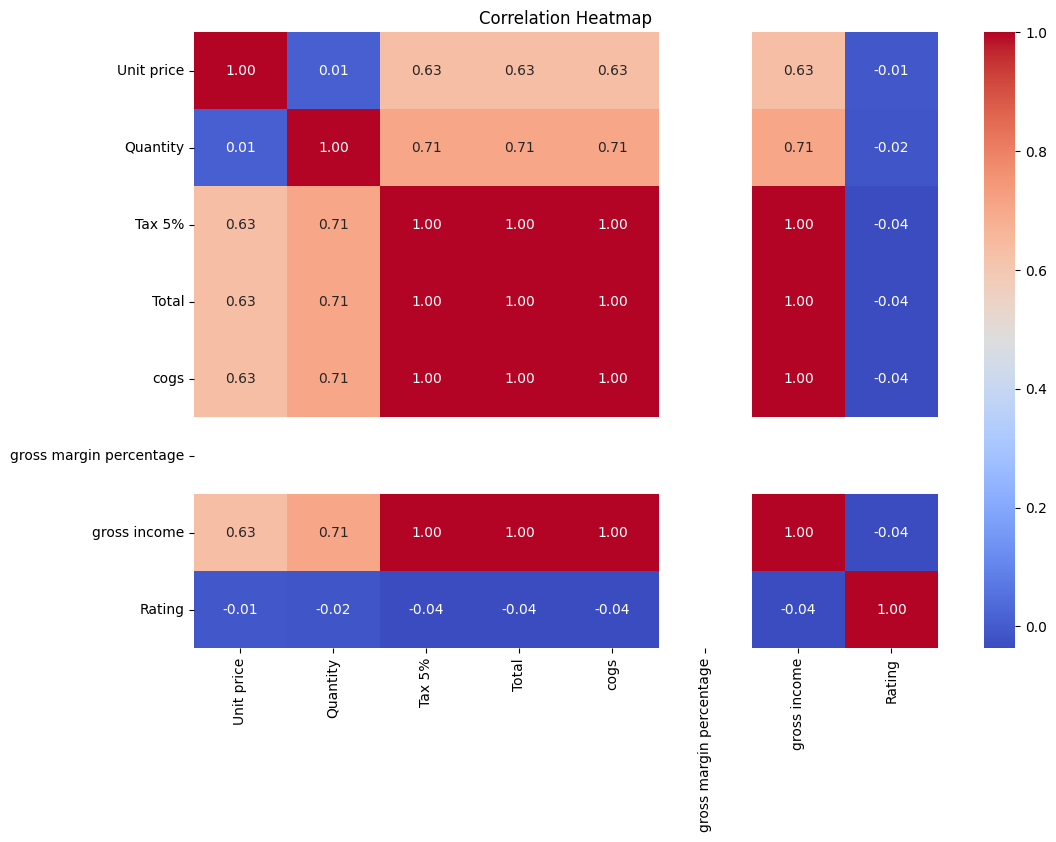

In [7]:
# 6. Heatmap of Correlations
# Select only numeric columns for correlation
numeric_df = df.select_dtypes(include=['number'])
# Generate the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

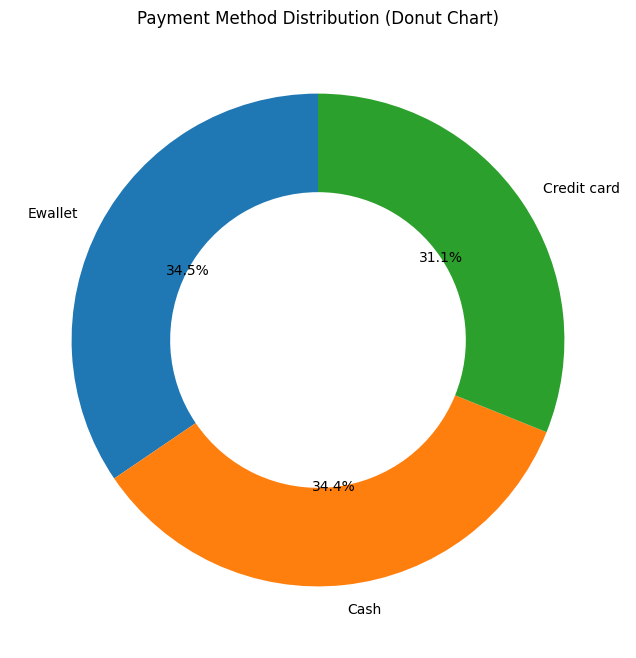

In [8]:
import matplotlib.pyplot as plt

# Payment Method Distribution
payment_counts = df['Payment'].value_counts()

# Donut Chart
plt.figure(figsize=(8, 8))
plt.pie(payment_counts, labels=payment_counts.index, autopct='%1.1f%%', startangle=90, wedgeprops={'width': 0.4})
plt.title('Payment Method Distribution (Donut Chart)')
plt.show()


# **Model training**

In [10]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
import joblib

# Step 1: Load Data
df = pd.read_excel('supermarket dataset.xlsx')

# Step 2: Clean column names by stripping any spaces or unwanted characters
df.columns = df.columns.str.strip()

# Step 3: Convert Date and Create DateTime Column
df['Date'] = pd.to_datetime(df['Date'])
df['Time'] = df['Time'].astype(str)  # Convert Time to string format
df['DateTime'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Time'])
df.drop(columns=['Date', 'Time'], inplace=True)

# Step 4: Handle Missing Values
df.fillna(0, inplace=True)

# Step 5: Encode Categorical Variables (Exclude 'Product line', 'City', 'Branch')
label_encoders = {}
categorical_columns = ['Customer type', 'Gender', 'Payment']  # Exclude 'Product line', 'City', 'Branch'
for column in categorical_columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

# Step 6: Feature Engineering: Date-Time Features
df['Year'] = df['DateTime'].dt.year
df['Month'] = df['DateTime'].dt.month
df['Day'] = df['DateTime'].dt.day
df['DayOfWeek'] = df['DateTime'].dt.dayofweek
df['Hour'] = df['DateTime'].dt.hour

# Step 7: Add Additional Columns
df['RevenuePerUnit'] = df['Unit price'] * df['Quantity']
df['TotalTaxAmount'] = df['Total'] * 0.05
df['IsWeekend'] = df['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)
df.drop(columns=['DateTime'], inplace=True)

# Step 8: Log Transformation
df['LogQuantity'] = np.log1p(df['Quantity'])
df['LogTotal'] = np.log1p(df['Total'])
df['LogGrossIncome'] = np.log1p(df['gross income'])

# Step 9: Interaction Feature: Quantity * Unit Price
df['QuantityUnitPrice'] = df['Quantity'] * df['Unit price']

# Step 10: Outlier Treatment for 'Total'
Q1 = df['Total'].quantile(0.25)
Q3 = df['Total'].quantile(0.75)
IQR = Q3 - Q1
df = df[(df['Total'] >= Q1 - 1.5 * IQR) & (df['Total'] <= Q3 + 1.5 * IQR)]

# Step 11: Scaling Numerical Features (Exclude 'Product line', 'City', 'Branch')
numerical_features = ['Unit price', 'Quantity', 'Tax 5%', 'gross income', 'Rating', 'RevenuePerUnit',
                      'TotalTaxAmount', 'LogQuantity', 'LogTotal', 'LogGrossIncome', 'QuantityUnitPrice',
                      'IsWeekend', 'Year', 'Month', 'Day', 'DayOfWeek', 'Hour']

# Ensure that all categorical columns have been encoded properly
df[numerical_features] = df[numerical_features].apply(pd.to_numeric, errors='coerce')

# Step 12: Check for Non-Numeric Columns in X
X = df.drop(columns=['Total'])  # Features
y = df['Total']  # Target

# Check for any non-numeric columns in X
non_numeric_columns = X.select_dtypes(include=['object']).columns
if len(non_numeric_columns) > 0:
    # Handle these columns, e.g., encode or drop them.
    X = X.drop(columns=non_numeric_columns)  # Drop non-numeric columns for now

# Step 13: Split Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 14: Scale the Data (Standardize)
scaler = StandardScaler()
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

# Step 15: Train Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_train, y_train)

# Step 16: Make Predictions
y_pred = rf_regressor.predict(X_test)

# Step 17: Evaluate the Model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R²): {r2}")

# Step 18: Save the Trained Model
joblib.dump(rf_regressor, 'random_forest_regressor.pkl')
print("Model saved as 'random_forest_regressor.pkl'")

# Step 19: Example: Load and Use the Saved Model
loaded_model = joblib.load('random_forest_regressor.pkl')
new_data = X_test.iloc[0:1]  # Example: Use the first row of the test set
new_prediction = loaded_model.predict(new_data)
print(f"Prediction for new data: {new_prediction}")


Mean Squared Error (MSE): 3.1948962774591454
R-squared (R²): 0.9999504261908787
Model saved as 'random_forest_regressor.pkl'
Prediction for new data: [19.10244]


# **Hyperparameter tuning**

Mean Squared Error: 0.005761672313407963
R-squared: 0.990994983306287


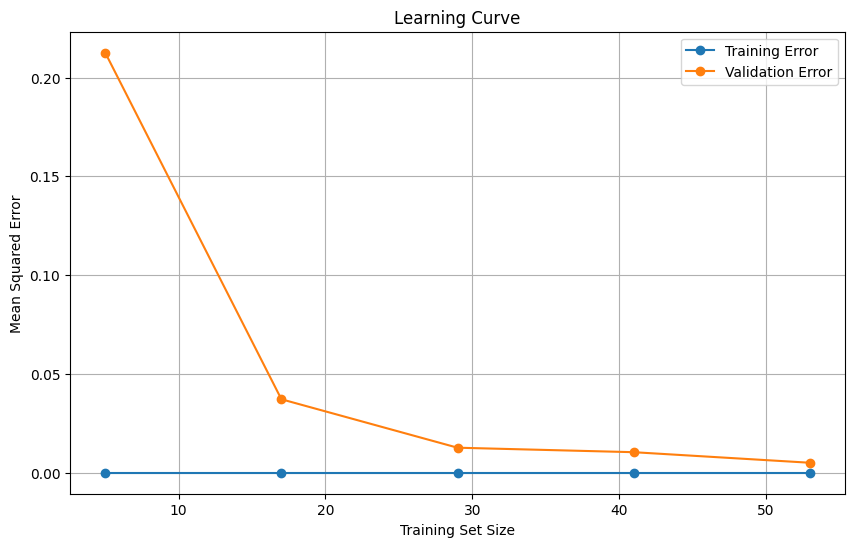

Model saved to random_forest_model.pkl
Loaded model MSE: 0.005761672313407963


In [36]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, learning_curve
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import joblib

# Step 1: Load Data
df = pd.read_excel('supermarket dataset.xlsx')
df = df.sample(frac=0.1, random_state=42)  # Use 10% of the data

# Step 2: Preprocess Data
df['Date'] = pd.to_datetime(df['Date'])
df['DateTime'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Time'].astype(str))
df.drop(columns=['Date', 'Time', 'Invoice ID'], inplace=True)

# Label Encoding
categorical_columns = ['Customer type', 'Gender', 'Payment', 'City', 'Branch', 'Product line']
for column in categorical_columns:
    df[column] = LabelEncoder().fit_transform(df[column])

# Feature Engineering
df['RevenuePerUnit'] = df['Unit price'] * df['Quantity']
df['LogTotal'] = np.log1p(df['Total'])

# Step 2.1: Calculate Profit Margin
# Profit Margin is calculated as (Total - Cost of Goods Sold) / Total
df['ProfitMargin'] = (df['Total'] - df['cogs']) / df['Total']
df['ProfitMargin'] = df['ProfitMargin'].fillna(0)  # Handle any NaN values

# Step 2.2: Calculate Optimized Sales
# Optimized Sales = Total + (Total * Profit Margin)
df['OptimizedSales'] = df['Total'] + (df['Total'] * df['ProfitMargin'])

# Prepare Features and Target
X = df[['Unit price', 'Quantity', 'Tax 5%', 'Rating', 'RevenuePerUnit', 'ProfitMargin', 'OptimizedSales']]
y = df['LogTotal']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale Data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Step 3: Hyperparameter Tuning
param_distributions = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

rf = RandomForestRegressor(random_state=42)
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_distributions,
    n_iter=10,  # Reduced iterations
    cv=3,       # Reduced folds
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1
)
random_search.fit(X_train, y_train)
best_rf = random_search.best_estimator_

# Step 4: Model Evaluation
y_pred = best_rf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

# Step 5: Learning Curve
def plot_learning_curve(estimator, X, y):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=3, scoring='neg_mean_squared_error', train_sizes=np.linspace(0.1, 1.0, 5), n_jobs=-1
    )
    train_scores_mean = -train_scores.mean(axis=1)
    test_scores_mean = -test_scores.mean(axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, label="Training Error", marker='o')
    plt.plot(train_sizes, test_scores_mean, label="Validation Error", marker='o')
    plt.title("Learning Curve")
    plt.xlabel("Training Set Size")
    plt.ylabel("Mean Squared Error")
    plt.legend()
    plt.grid()
    plt.show()

plot_learning_curve(best_rf, X_train, y_train)

# Step 6: Save the dataset with new columns
output_file = 'profits.csv'
df.to_csv(output_file, index=False)

# Step 7: Save the trained model to a .pkl file
model_file = 'random_forest_model.pkl'
joblib.dump(best_rf, model_file)
print(f"Model saved to {model_file}")

# Step 8: (Optional) Load the model back to verify
loaded_model = joblib.load(model_file)
y_pred_loaded = loaded_model.predict(X_test)
print(f"Loaded model MSE: {mean_squared_error(y_test, y_pred_loaded)}")


# **Model evaluation and accuracy**

In [12]:
# Step 4: Model Evaluation
# Predictions for Training and Testing Data
y_train_pred = best_rf.predict(X_train)
y_test_pred = best_rf.predict(X_test)

# Calculate Metrics
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred) * 100  # Convert R² to percentage
test_r2 = r2_score(y_test, y_test_pred) * 100  # Convert R² to percentage

# Display Results
print("Model Performance:")
print(f"Training Mean Squared Error: {train_mse:.4f}")
print(f"Testing Mean Squared Error: {test_mse:.4f}")
print(f"Training Accuracy: {train_r2:.2f}%")
print(f"Testing Accuracy: {test_r2:.2f}%")


Model Performance:
Training Mean Squared Error: 0.0000
Testing Mean Squared Error: 0.0058
Training Accuracy: 100.00%
Testing Accuracy: 99.10%


# **Performance Analysis**

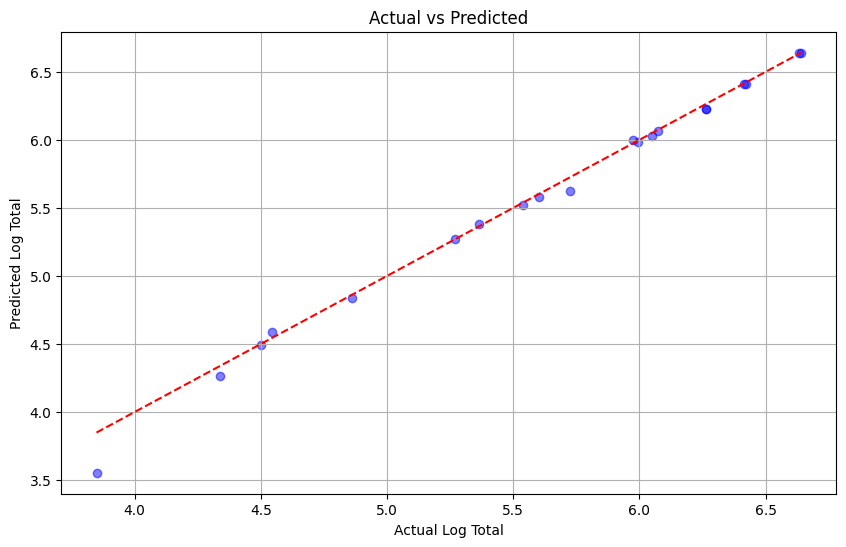

In [18]:

# Plot the Predictions vs Actual
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.title("Actual vs Predicted")
plt.xlabel("Actual Log Total")
plt.ylabel("Predicted Log Total")
plt.grid(True)
plt.show()


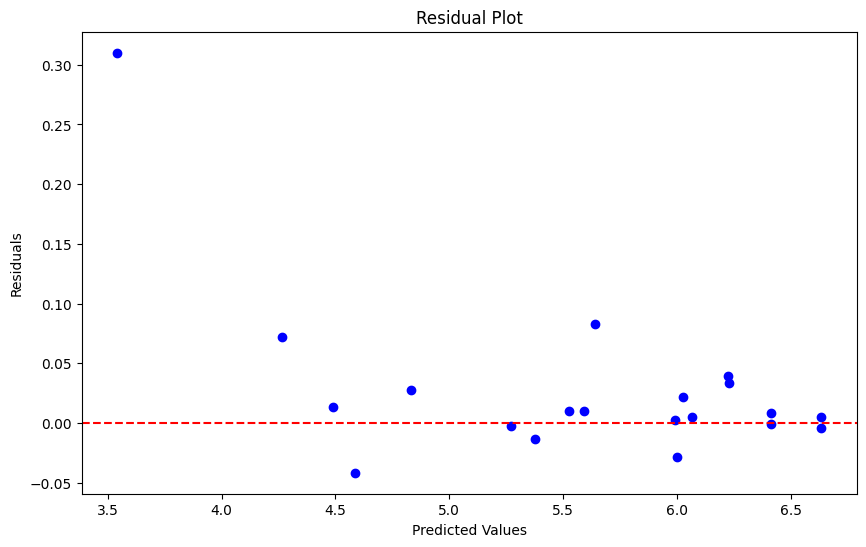

In [21]:
# Calculate residuals
residuals = y_test - y_pred

# Plot residuals
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, color='blue')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()


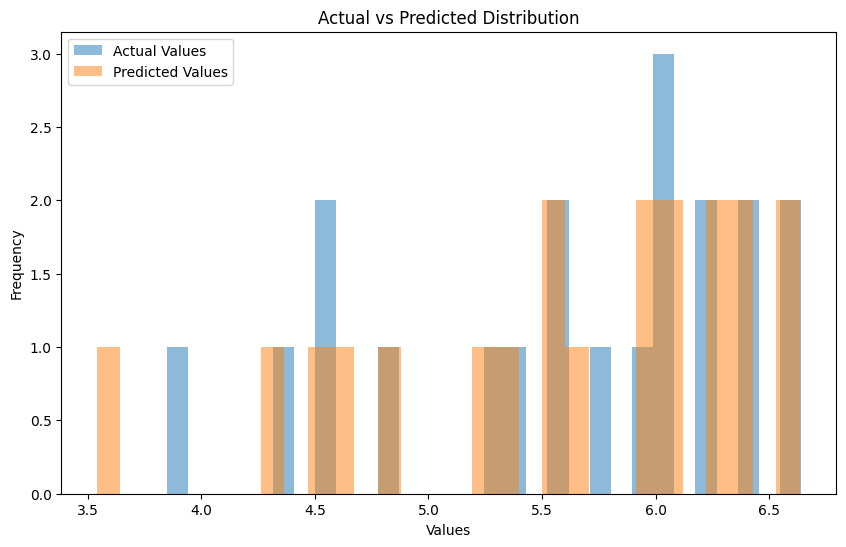

In [23]:
# Actual vs Predicted Distribution
plt.figure(figsize=(10, 6))
plt.hist(y_test, bins=30, alpha=0.5, label='Actual Values')
plt.hist(y_pred, bins=30, alpha=0.5, label='Predicted Values')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Actual vs Predicted Distribution')
plt.legend()
plt.show()


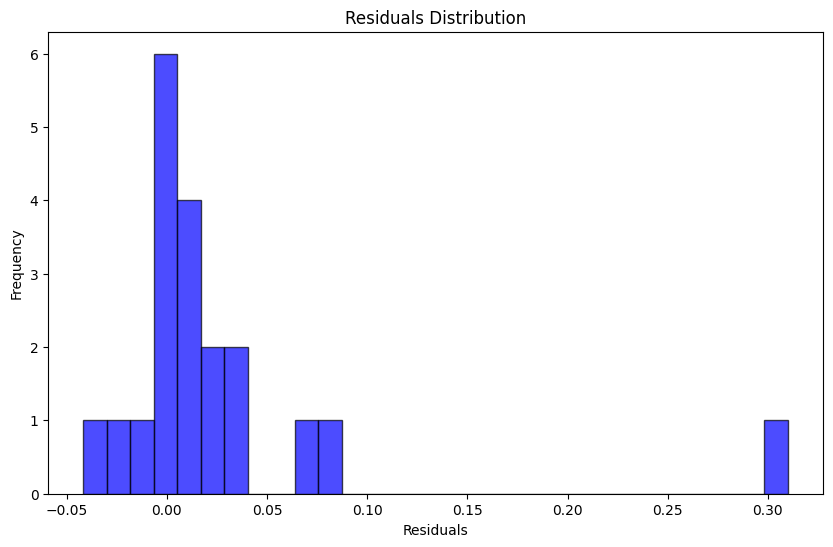

In [24]:
# Residuals Distribution
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, color='blue', edgecolor='black', alpha=0.7)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residuals Distribution')
plt.show()


# **Code quality checking using pylint**

In [25]:
!pip install pylint


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.9/521.9 kB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.6/274.6 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.3/92.3 kB 7.3 MB/s eta 0:00:00


In [34]:
code = """
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, learning_curve
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import joblib

# Step 1: Load Data
df = pd.read_excel('supermarket dataset.xlsx')
df = df.sample(frac=0.1, random_state=42)  # Use 10% of the data

# Step 2: Preprocess Data
df['Date'] = pd.to_datetime(df['Date'])
df['DateTime'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Time'].astype(str))
df.drop(columns=['Date', 'Time', 'Invoice ID'], inplace=True)

# Label Encoding
categorical_columns = ['Customer type', 'Gender', 'Payment', 'City', 'Branch', 'Product line']
for column in categorical_columns:
    df[column] = LabelEncoder().fit_transform(df[column])

# Feature Engineering
df['RevenuePerUnit'] = df['Unit price'] * df['Quantity']
df['LogTotal'] = np.log1p(df['Total'])

# Step 2.1: Calculate Profit Margin
# Profit Margin is calculated as (Total - Cost of Goods Sold) / Total
df['ProfitMargin'] = (df['Total'] - df['cogs']) / df['Total']
df['ProfitMargin'] = df['ProfitMargin'].fillna(0)  # Handle any NaN values

# Step 2.2: Calculate Optimized Sales
# Optimized Sales = Total + (Total * Profit Margin)
df['OptimizedSales'] = df['Total'] + (df['Total'] * df['ProfitMargin'])

# Prepare Features and Target
X = df[['Unit price', 'Quantity', 'Tax 5%', 'Rating', 'RevenuePerUnit', 'ProfitMargin', 'OptimizedSales']]
y = df['LogTotal']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale Data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Step 3: Hyperparameter Tuning
param_distributions = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

rf = RandomForestRegressor(random_state=42)
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_distributions,
    n_iter=10,  # Reduced iterations
    cv=3,       # Reduced folds
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1
)
random_search.fit(X_train, y_train)
best_rf = random_search.best_estimator_

# Step 4: Model Evaluation
y_pred = best_rf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

# Step 5: Learning Curve
def plot_learning_curve(estimator, X, y):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=3, scoring='neg_mean_squared_error', train_sizes=np.linspace(0.1, 1.0, 5), n_jobs=-1
    )
    train_scores_mean = -train_scores.mean(axis=1)
    test_scores_mean = -test_scores.mean(axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, label="Training Error", marker='o')
    plt.plot(train_sizes, test_scores_mean, label="Validation Error", marker='o')
    plt.title("Learning Curve")
    plt.xlabel("Training Set Size")
    plt.ylabel("Mean Squared Error")
    plt.legend()
    plt.grid()
    plt.show()

plot_learning_curve(best_rf, X_train, y_train)

# Step 6: Save the dataset with new columns
output_file = 'profits.csv'
df.to_csv(output_file, index=False)

# Step 7: Save the trained model to a .pkl file
model_file = 'random_forest_model.pkl'
joblib.dump(best_rf, model_file)
print(f"Model saved to {model_file}")

# Step 8: (Optional) Load the model back to verify
loaded_model = joblib.load(model_file)
y_pred_loaded = loaded_model.predict(X_test)
print(f"Loaded model MSE: {mean_squared_error(y_test, y_pred_loaded)}")

"""
# Save the code to a file
with open("script.py", "w") as file:
    file.write(code)


In [35]:
!pylint script.py


************* Module script
script.py:39:0: C0301: Line too long (106/100) (line-too-long)
script.py:82:0: C0301: Line too long (112/100) (line-too-long)
script.py:112:0: C0305: Trailing newlines (trailing-newlines)
script.py:1:0: C0114: Missing module docstring (missing-module-docstring)
script.py:80:0: C0116: Missing function or method docstring (missing-function-docstring)
script.py:80:35: C0103: Argument name "X" doesn't conform to snake_case naming style (invalid-name)
script.py:80:35: W0621: Redefining name 'X' from outer scope (line 39) (redefined-outer-name)
script.py:80:38: W0621: Redefining name 'y' from outer scope (line 40) (redefined-outer-name)
script.py:100:0: C0103: Constant name "output_file" doesn't conform to UPPER_CASE naming style (invalid-name)
script.py:104:0: C0103: Constant name "model_file" doesn't conform to UPPER_CASE naming style (invalid-name)

------------------------------------------------------------------
Your code has been rated at 8.31/10 (previous 